## Scrapping

En primer lugar comenzamos definiendo el objeto reddit, y realizamos una serie de pruebas para empezar a scrappear la informacion de reddit.

In [13]:
from time import sleep

In [14]:
import praw

# Configura tu conexión con Reddit
reddit = praw.Reddit(
    client_id="XEVqTpGA9HE6MNujQAWt1w",
    client_secret="bv4J3usOH-V__I4tGD__bLoWnGA_Sg",
    user_agent="Testing_api",
    read_only=True
)



Vamos a comenzar a buscar en el subreddit de la tierra plana, y ver que resultados obtenemos.


In [15]:
# Define el subreddit y la búsqueda
subreddit_name = "flatearth"

queries_list = [
    "flat earth",
]

resultados_totales = set()

subredit = reddit.subreddit(subreddit_name)

# Realiza la búsqueda en el subreddit
for query in queries_list:
    print(f"Buscando en el subreddit {subreddit_name} con la consulta '{query}'")
    resultados = subredit.search(query, limit=100)
    
    # Itera sobre los resultados
    for submission in resultados:
        # Verifica si el título ya está en los resultados totales
        if submission.title not in resultados_totales:
            resultados_totales.add(submission)

Buscando en el subreddit flatearth con la consulta 'flat earth'


Ahora vamos a comprobar que resultados hemos obtenido, y ver si podemos extraer la informacion de los posts.

In [16]:
#Tomamos el primer post de los resultados

post = list(resultados_totales)[0]

In [17]:
# Extraer el título y el contenido del post asi como el nombre del autor

print(f"Title: {post.title}")
print(f"Author: {post.author}")
print(f"Content: {post.selftext}")
print(f"URL: {post.url}")
print(f"Upvotes: {post.ups}")
print(f"Downvotes: {post.downs}")
print(f"Comments: {post.num_comments}")
print(f"Created: {post.created}")
print(f"Subreddit: {post.subreddit}")
print(f"Post ID: {post.id}")
print(f"Post URL: {post.url}")
print(f"Post Score: {post.score}")

print('\n\n')

#Navegar el arbol de comentarios
comentarios = post.comments

comentario = comentarios[0]
print(f"Comentario: {comentario.body}")
print(f"Autor: {comentario.author}")
print(f"Upvotes: {comentario.ups}")
print(f"Downvotes: {comentario.downs}")
print(f"Created: {comentario.created}")
print(f"Comentario ID: {comentario.id}")
print(f"Comentario URL: {comentario.permalink}")
print(f"Comentario Score: {comentario.score}")

Title: The Earth isn't flat.
Author: XYSunshine
Content: 
URL: https://i.redd.it/ius8hoezfm0d1.jpeg
Upvotes: 200
Downvotes: 0
Comments: 198
Created: 1715792490.0
Subreddit: flatearth
Post ID: 1cspu8e
Post URL: https://i.redd.it/ius8hoezfm0d1.jpeg
Post Score: 200



Comentario: No stars? Must be fake
Autor: MightBeBren
Upvotes: 53
Downvotes: 0
Created: 1715793607.0
Comentario ID: l46nbfa
Comentario URL: /r/flatearth/comments/1cspu8e/the_earth_isnt_flat/l46nbfa/
Comentario Score: 53


Vemos que estamos extrayendo la información de los posts, y de todos los comentarios, asi como comentarios de comentarios, puesto que estamos extrayendo una lista aplanada que contiene todos los comentarios que tendrían forma de árbol.

## Limitaciones y problemas.

- Nos encontramos con una limitacion, cada vez que hacemos una querie, dentro de un subreddit solamente podemos obtener un máximo de 100 posts, que es lo que nos devuelve la API de reddit. Por lo que si queremos obtener más posts, tenemos que hacer varias queries, y unir los resultados.
- La API de reddit tiene un límite de peticiones por segundo, por lo que si hacemos muchas peticiones en poco tiempo, nos puede bloquear la cuenta. Por lo que tenemos que tener cuidado con esto.
- Podríamos obtener resultados duplicados, por lo que tenemos que comprobar si el post ya existe en los resultados totales.
- debemos intentar encontrar resultados de la gente lo más convencida posible para evitar el ruido que se pueda generar por memes y posts

Una posible solución a esto, es hacer una lista de palabras clave, y hacer una búsqueda por cada palabra clave, y unir los resultados. De esta forma, podemos obtener más resultados, y evitar el ruido que se pueda generar por memes y posts.

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

## Funciones de scrapping

Vamos a definir una serie de funciones que nos permitan scrappear la información de reddit, y guardarla en un grafo. Para ello, vamos a utilizar la libreria networkx.

In [19]:
def get_results(subreddit, query_list, n_post = 10):
    resultados_totales = set()
    
    subredit = reddit.subreddit(subreddit)
    
    for query in query_list:
        print(f"Buscando en el subreddit {subreddit} con la consulta '{query}'")
        
        try:
        
            resultados = subredit.search(query, limit=n_post)
            
            for submission in resultados:
                # Verifica si el título ya está en los resultados totales
                if submission.title not in resultados_totales:
                    resultados_totales.add(submission)
                    
        except Exception:
            continue
                
    return resultados_totales


Esta funcion permite encontrar posts dado un sub subreddit y una lista de 'palabras clave'

In [20]:
def scrapear_subreddit(subreddit, query_list, n_post = 10, max_comments = None):
    
    # Obtener los resultados
    resultados_totales = get_results(subreddit, query_list, n_post)

    # Agregar nodo raíz al grafo
    grafo.add_node(subreddit)
    
    # Agregar los nodos y aristas al grafo
    for post in tqdm(list(resultados_totales)):
        if post.author:
            grafo.add_node(post.author.name,subreddit=subreddit)
            grafo.add_edge(subreddit, post.author.name)
            
        while True:
            try:
                post.comments.replace_more(limit=None)
                break
            except Exception:
                print('demasiadas peticiones')
                sleep(10)
            
        comentarios = sorted(post.comments.list(), key=lambda x: x.score, reverse=True)
        
        for comentario in comentarios:
            if comentario.author:
                #comprueba que el nodo ya existe
                if grafo.has_node(comentario.author.name):
                    if not grafo.has_edge(post.author.name, comentario.author.name):
                        grafo.add_edge(post.author.name, comentario.author.name)
                        
        if max_comments is not None:
            comentarios = comentarios[:max_comments]
        
        for comentario in comentarios:
            if comentario.author:
                grafo.add_node(comentario.author.name, subreddit=subreddit)
                #comprobar que no exista ya la arista
                if not grafo.has_edge(post.author.name, comentario.author.name):
                    grafo.add_edge(post.author.name, comentario.author.name)

Esta funcion permite scrapear un subreddit, y guardar la información en un grafo.

In [22]:
# Probamos entonces nuestra funcion de scrapping.
grafo = nx.Graph()

scrapear_subreddit('flatearth', ['flatearth'], n_post = 10)
scrapear_subreddit('antivaccine', ['antivaccine'], n_post = 10)


Buscando en el subreddit flatearth con la consulta 'flatearth'


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Buscando en el subreddit antivaccine con la consulta 'antivaccine'


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Numero de nodos: 1553
Numero de aristas: 1654
Numero de componentes: 2
Promedio de grado: 2.130070830650354
Promedio de clustering: 0.0020872147617880593


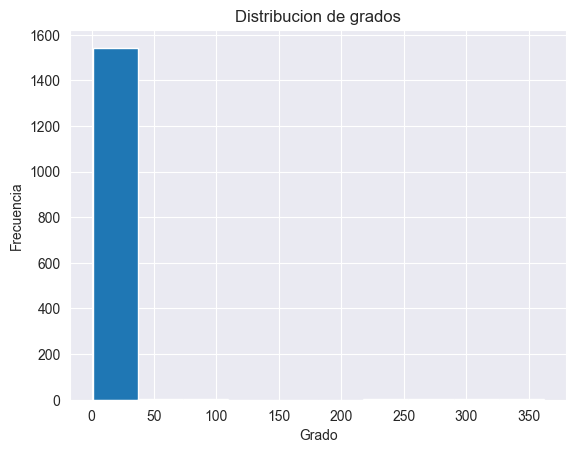

In [29]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

# Y un histograma de la distribucion de grados

plt.hist([grafo.degree(nodo) for nodo in grafo.nodes()])
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.title('Distribucion de grados')
plt.show()


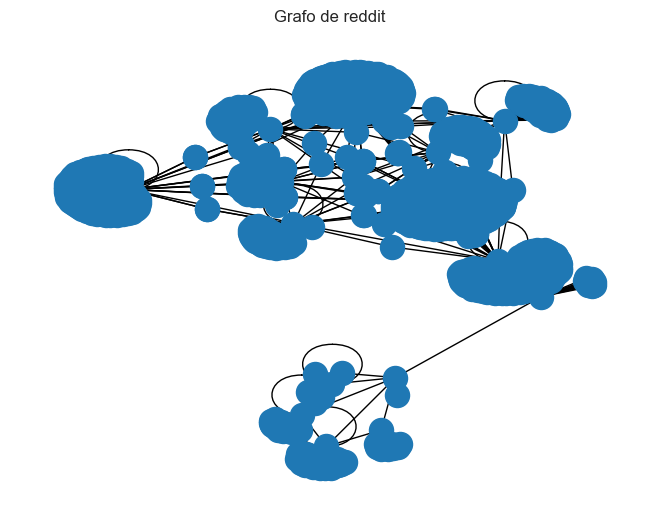

In [32]:
# Vamos a ver el grafo

nx.draw(grafo)
plt.title('Grafo de reddit')
plt.show()

In [135]:
#exporta el grafo a un archivo GML

nx.write_gml(grafo, "grafo.gml")

## Preparando las queries para el grafo definitivo.



In [14]:
lista_comunes = ["critical thinking", "question everything", "pseudoscience",  "debunk", "denial", "conspiracy"]

subreddit_keywords = {
    'FlatEarth': [
        'flat earth theory',
        'ice wall discovery',
        'antarctic cover‑up',
        'horizon anomaly',
        'ground is level',
        *lista_comunes
    ],
    'moonlandinghoax': [
        'fake lunar mission',
        'studio filmed moon',
        'camera glitch proof',
        'lunar module lies',
        'NASA backlot conspiracy',
        *lista_comunes
    ],
    'aliens': [
        'ufo disclosure',
        'area 51 secrets',
        'extraterrestrial visit',
        'crop circle proof',
        'alien cover‑up',
        *lista_comunes
    ],
    'No5G': [
        '5g health risks',
        'radiation cover‑up',
        'cell tower danger',
        'electromagnetic fraud',
        'hidden toxicity',
        *lista_comunes
    ],
    'chemtrails': [
        'chemical spraying',
        'aerosol cover‑up',
        'geoengineering proof',
        'toxics in sky',
        'secret air program',
        *lista_comunes
    ],
    'antiVaxx': [
        'big pharma lies',
        'vaccine injury cover‑up',
        'unreported side effects',
        'injection fraud',
        'medical experimentation',
        *lista_comunes
    ],
    'pesticideconspiracy': [
        'pesticide runoff cover‑up',
        'agrochemical conspiracy',
        'glyphosate danger',
        'farmers whistleblower',
        'toxic crop spraying',
        *lista_comunes
    ],
    'CovidConspiracy': [
        'plandemic proof',
        'virus lab leak cover‑up',
        'mask mandate fraud',
        'PCR gate',
        'vaccine passport tyranny',
        *lista_comunes
    ],
    'climatechangeisalie': [
        'co2 myth',
        'green agenda',
        'warming scam',
        'carbon tax cover‑up',
        'environment fraud',
        *lista_comunes
    ],
    'newworldorder': [
        'one world government',
        'global elite plan',
        'shadow government proof',
        'population control agenda',
        'nwo conspiracy',
        *lista_comunes
    ],
    
    'SimulationTheory': [
        'we live in a simulation',
        'matrix is real',
        'simulated reality proof',
        'glitch in the matrix',
        'reality is fake',
        'computer-generated universe',
        'consciousness and simulation',
        'base reality hypothesis',
        'elon musk simulation',
        'philosophical zombies',
        *lista_comunes
    ],
    'Plandemic': [
        'covid was planned',
        'virus patent evidence',
        'event 201 proof',
        'pandemic simulation cover-up',
        'vaccine agenda',
        'plandemic documentary',
        'mass control operation',
        'false positive PCR',
        'big pharma profits',
        'government fear propaganda',
        *lista_comunes
    ],
    'DebateHolocaust': [
        'holocaust exaggeration claims',
        'gas chamber doubts',
        'revisionist history',
        'ww2 narrative question',
        'auschwitz controversy',
        'truth about holocaust',
        'holocaust denial arguments',
        'zionist agenda claims',
        'nuremberg trials critique',
        'forbidden historical facts',
        *lista_comunes
    ],
    'Epstein': [
        'epstein didn’t kill himself',
        'epstein client list',
        'ghislaine maxwell secrets',
        'elite pedophile ring',
        'epstein island evidence',
        'blackmail operation',
        'intelligence agency ties',
        'jeffrey epstein cover‑up',
        'flight logs secrets',
        'missing surveillance tapes',
        *lista_comunes
    ]
}

Lanzamos el scrapeo de todos los subreddits, y guardamos la información en un grafo. Para ello, vamos a utilizar la libreria networkx.

In [ ]:
#crea un grafo vacio
grafo = nx.Graph()

for subreddit, queries in subreddit_keywords.items():
    scrapear_subreddit(subreddit, queries, n_post = 10)

# Exporta el grafo a un archivo GML
nx.write_gml(grafo, "grafo.gml")

## Analizando el grafo

Vamos a analizar el grafo, y ver que podemos obtener de el.

In [33]:
# Cargar el grafo desde el archivo GML
grafo = nx.read_gml("grafo.gml")

In [34]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

Numero de nodos: 31116
Numero de aristas: 40704
Numero de componentes: 7
Promedio de grado: 2.616274585422291
Promedio de clustering: 0.012377215584854924
